Load Libraries :

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime as dt
sns.set()

from skimpy import skim
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_absolute_error,mean_squared_error
from keras.models import Sequential
import tensorflow as tf


Load Raw_Data :

In [3]:
raw_data=pd.read_csv("prices.csv")
dataset_1=raw_data.copy()
dataset_1.head()

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


Explorartory Data Analysis :

In [4]:
skim(dataset_1)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 851264 │ │ float64     │ 5     │                                                          │
│ │ Number of columns │ 7      │ │ string      │ 2     │                                                          │
│ └───────────────────┴────────┘ └─────────────┴───────┘                                                          │
│                                                     number                                                      │
│ ┏━━━━━━━━━━━━━━┳━━━━━┳━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━┓  │
│ ┃ column_name  ┃ NA  ┃ NA %  ┃ mean     ┃ sd       ┃ p0   ┃ p25     ┃ p50     ┃ p75     ┃ p100      ┃ hist   ┃  │
│ ┡━━━━━━━━━━━━━━╇━━━━━╇━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━┩  │
│ │ open         │   0 │     0 │    70.84 │     83.7 │ 0.85 │   33.84 │   52.77 │   79.88 │      1584 │   ▇    │  │
│ │ close        │   0 │     0 │    70.86 │    83.69 │ 0.86 │   33.85 │    52.8 │   79.89 │      1578 │   ▇    │  │
│ │ low          │   0 │     0 │    70.12 │    82.88 │ 0.83 │   33.48 │   52.23 │   79.11 │      1550 │   ▇    │  │
│ │ high         │   0 │     0 │    71.54 │    84.47 │ 0.88 │   34.19 │   53.31 │   80.61 │      1601 │   ▇    │  │
│ │ volume       │   0 │     0 │  5415000 │ 12490000 │    0 │ 1222000 │ 2476000 │ 5222000 │ 859600000 │   ▇    │  │
│ └──────────────┴─────┴───────┴──────────┴──────────┴──────┴─────────┴─────────┴─────────┴───────────┴────────┘  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ date                      │       0 │          0 │                            1 │                   853403 │  │
│ │ symbol                    │       0 │          0 │                            1 │                   851264 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [5]:
c=dataset_1.columns
for i in c :
    print(i,':',len(dataset_1[i]))

def find_duplicates(data):
  duplicates = []
  seen = set()
  for value in data:
    if value in seen:
      duplicates.append(value)
    else:
      seen.add(value)
  return duplicates
duplicates = find_duplicates(dataset_1)
print('duplicates:',duplicates)
print('nall :',dataset_1.isnull().sum())

date : 851264
symbol : 851264
open : 851264
close : 851264
low : 851264
high : 851264
volume : 851264
duplicates: []
nall : date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64


In [6]:
dataset_1['date']=dataset_1['date'].apply(lambda x:x.split()[0])
dataset_1['date']=pd.to_datetime(dataset_1['date'])
dataset_1['date']=dataset_1['date'].dt.strftime('%Y-%m-%d')
dataset_1.sort_values(by='date',ignore_index=True,inplace=True)

In [7]:
def company(company,start_date,end_date):
    company_unique=dataset_1[dataset_1['symbol']==company]    
    company_unique = company_unique.copy() 
    company_unique['date'] = pd.to_datetime(company_unique['date']) 
    start_end_company = company_unique[(company_unique['date'] > start_date) & (company_unique['date'] < end_date)]
    return start_end_company

In [8]:
com=np.random.choice(dataset_1['symbol'].unique())
date_format = "%Y-%m-%d" 
start_date = dt.strptime(dataset_1['date'].min(), date_format)
end_date = dt.strptime(dataset_1['date'].max(), date_format)
data_comapany_unique = company(com,start_date,end_date)
data_comapany_unique.sort_values(by='date',ignore_index=True,inplace=True)
data_comapany_unique.head()

,date,symbol,open,close,low,high,volume
0,2010-01-05,LEN,12.95,13.55,12.72,13.60,6205100.0
1,2010-01-06,LEN,13.51,13.70,13.25,13.75,6363000.0
2,2010-01-07,LEN,14.93,15.46,14.62,16.00,28709400.0
3,2010-01-08,LEN,15.40,15.95,15.19,16.07,8641500.0
4,2010-01-11,LEN,16.07,16.26,15.98,16.35,6404600.0


In [9]:
data_comapany_unique['closeDiff'] = data_comapany_unique['close'].shift(-1) - data_comapany_unique['close']
data_comapany_unique['Return'] = data_comapany_unique['closeDiff']/ data_comapany_unique['close']
data_comapany_unique['Direction'] = [1 if data_comapany_unique['closeDiff'].loc[ei] > 0 else 0 for ei in data_comapany_unique.index ]
data_comapany_unique['MA30'] = data_comapany_unique['close'].rolling(30).mean()
data_comapany_unique['MA60'] = data_comapany_unique['close'].rolling(60).mean()
data_comapany_unique.dropna(inplace=True)
data_comapany_unique['Shares'] = [1 if data_comapany_unique.loc[ei, 'MA30']>data_comapany_unique.loc[ei, 'MA60'] else 0 for ei in data_comapany_unique.index]
data_comapany_unique.describe(include='all').T

,count,unique,top,freq,mean,min,25%,50%,75%,max,std
date,1700,NaN,NaN,NaN,2013-08-13 23:12:33.882352896,2010-03-31 00:00:00,2011-12-04 06:00:00,2013-08-14 12:00:00,2015-04-23 06:00:00,2016-12-28 00:00:00,NaN
symbol,1700,1,LEN,1700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
open,1700.0,NaN,NaN,NaN,34.316465,12.4,20.17,38.274999,43.8825,55.360001,12.230526
close,1700.0,NaN,NaN,NaN,34.302182,12.71,20.199999,38.244999,43.797501,55.59,12.219003
low,1700.0,NaN,NaN,NaN,33.811835,11.93,19.815,37.725001,43.332501,54.810001,12.119921
high,1700.0,NaN,NaN,NaN,34.791918,12.82,20.5975,38.799999,44.3925,56.040001,12.311017
volume,1700.0,NaN,NaN,NaN,4359282.235294,725100.0,2681050.0,3787150.0,5406300.0,21750900.0,2456382.916789
closeDiff,1700.0,NaN,NaN,NaN,0.015112,-3.369999,-0.37,0.0,0.400001,2.879998,0.703274
Return,1700.0,NaN,NaN,NaN,0.000789,-0.092643,-0.01201,0.0,0.012754,0.129788,0.022475
Direction,1700.0,NaN,NaN,NaN,0.494706,0.0,0.0,0.0,1.0,1.0,0.500119


In [10]:
data_comapany_unique.head()

,date,symbol,open,close,low,high,volume,closeDiff,Return,Direction,MA30,MA60,Shares
59,2010-03-31,LEN,17.920000,17.209999,17.170000,18.040001,7739900.0,-0.080000,-0.004648,0,16.925000,16.298833,1
60,2010-04-01,LEN,17.320000,17.129999,17.010000,17.600000,5827400.0,0.430000,0.025102,1,16.928000,16.358500,1
61,2010-04-05,LEN,17.360001,17.559999,17.180000,17.730000,5323100.0,-0.269998,-0.015376,0,16.936333,16.422833,1
62,2010-04-06,LEN,17.459999,17.290001,17.049999,17.480000,4803600.0,-0.340000,-0.019665,0,16.940333,16.453333,1
63,2010-04-07,LEN,17.309999,16.950001,16.780001,17.520000,6215000.0,0.309999,0.018289,1,16.962667,16.470000,1


Visualization :

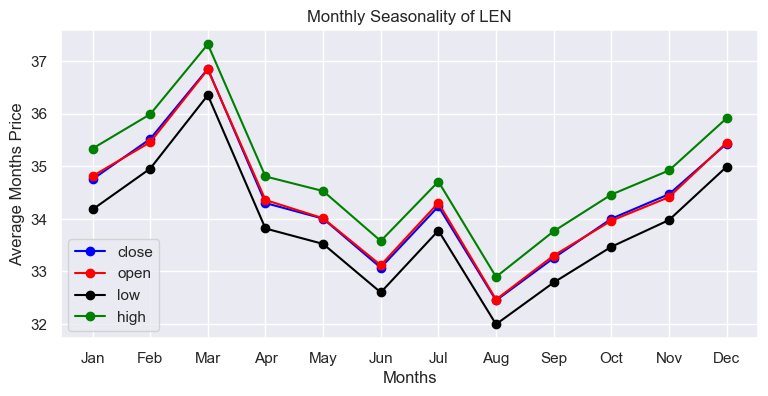

In [11]:
data_comapany_unique['Month'] = data_comapany_unique['date'].dt.month
monthly_close = data_comapany_unique.groupby('Month')['close'].mean()
monthly_open = data_comapany_unique.groupby('Month')['open'].mean()
monthly_low = data_comapany_unique.groupby('Month')['low'].mean()
monthly_high = data_comapany_unique.groupby('Month')['high'].mean()
plt.figure(figsize=(9, 4))
plt.plot(monthly_close.index, monthly_close.values, marker='o',color='blue', label='close',)
plt.plot(monthly_open.index, monthly_open.values, marker='o',color='red', label='open')
plt.plot(monthly_low.index, monthly_low.values, marker='o',color='black', label='low')
plt.plot(monthly_high.index, monthly_high.values, marker='o',color='green', label='high')
plt.title(f'Monthly Seasonality of {com}')
plt.xlabel('Months')
plt.ylabel('Average Months Price')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.legend()
plt.show()

In [12]:
data_comapany_unique.set_index(['date'],inplace=True)

In [13]:
plt.figure(figsize=(10,5))
data_comapany_unique_number=data_comapany_unique.select_dtypes(include='float64')
cor=data_comapany_unique_number.corr()
cor

,open,close,low,high,volume,closeDiff,Return,MA30,MA60
open,1.000000,0.998650,0.999311,0.999430,-0.400905,-0.034549,-0.041463,0.989579,0.980112
close,0.998650,1.000000,0.999459,0.999423,-0.402255,-0.036264,-0.043554,0.988632,0.979269
low,0.999311,0.999459,1.000000,0.999320,-0.412310,-0.035254,-0.042151,0.988787,0.979390
high,0.999430,0.999423,0.999320,1.000000,-0.391559,-0.035697,-0.042452,0.989503,0.980036
volume,-0.400905,-0.402255,-0.412310,-0.391559,1.000000,0.006459,0.011544,-0.400178,-0.407020
closeDiff,-0.034549,-0.036264,-0.035254,-0.035697,0.006459,1.000000,0.919241,-0.027299,-0.024393
Return,-0.041463,-0.043554,-0.042151,-0.042452,0.011544,0.919241,1.000000,-0.035388,-0.033564
MA30,0.989579,0.988632,0.988787,0.989503,-0.400178,-0.027299,-0.035388,1.000000,0.994870
MA60,0.980112,0.979269,0.979390,0.980036,-0.407020,-0.024393,-0.033564,0.994870,1.000000


<Figure size 1000x500 with 0 Axes>

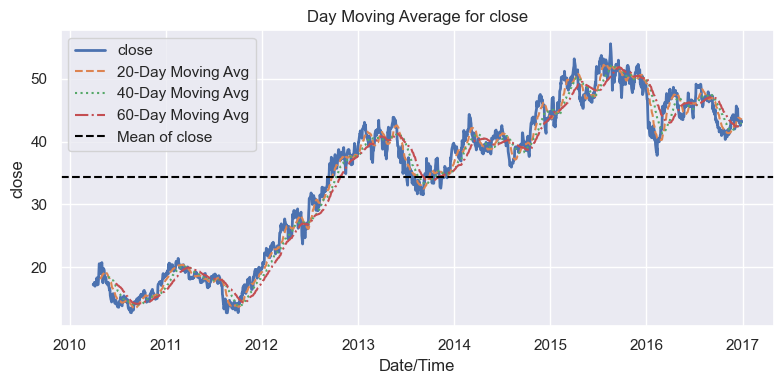

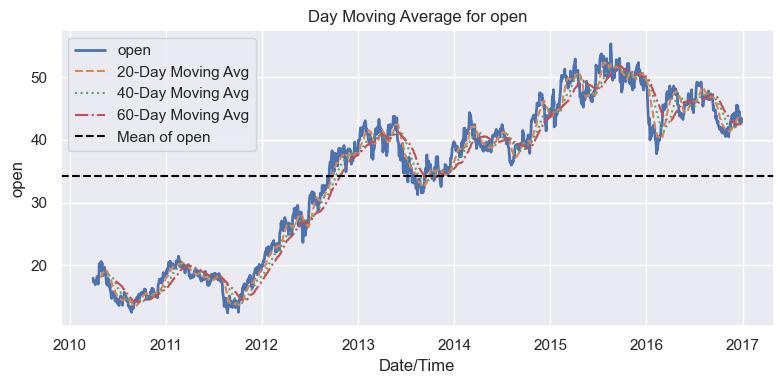

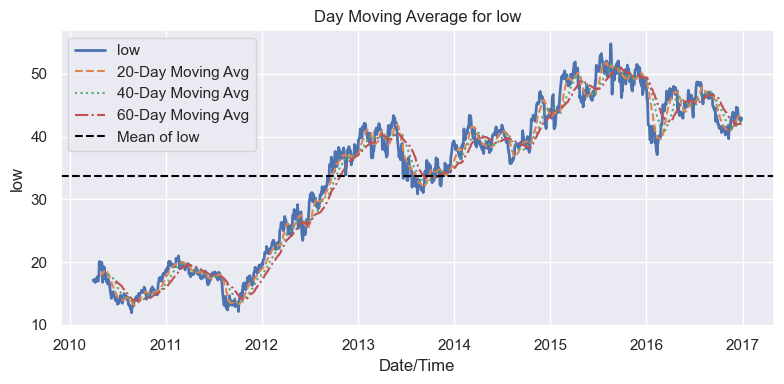

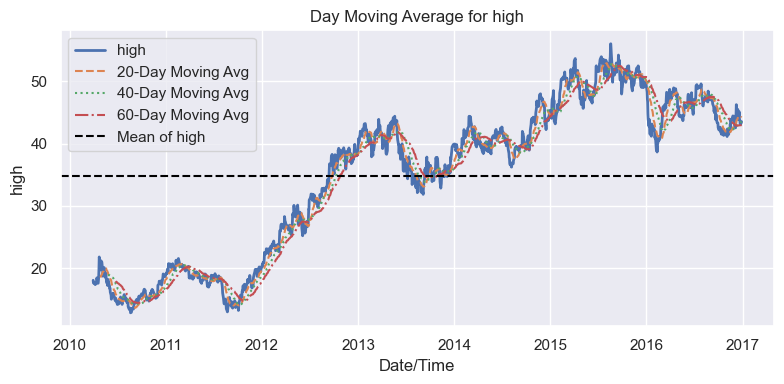

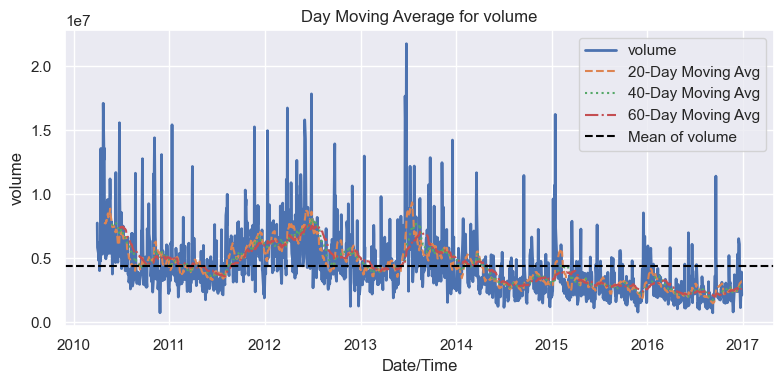

In [14]:
window_1 = 20
window_2 = 40
window_3 = 60

col = data_comapany_unique_number[['close','open','low','high','volume']]
for item in col:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(data_comapany_unique[item], label=item, linewidth=2)
    ax.plot(data_comapany_unique[item].rolling(window=window_1).mean(), label=f'{window_1}-Day Moving Avg', linestyle='--')
    ax.plot(data_comapany_unique[item].rolling(window=window_2).mean(), label=f'{window_2}-Day Moving Avg', linestyle='dotted')
    ax.plot(data_comapany_unique[item].rolling(window=window_3).mean(), label=f'{window_3}-Day Moving Avg', linestyle='-.')

    mean_value = data_comapany_unique[item].mean()
    
    plt.axhline(mean_value, linestyle='--', color='black', label=f'Mean of {item}') 
    # plt.gca().xaxis.set_major_formatter()
    ax.set_title(f'Day Moving Average for {item}')
    ax.set_xlabel('Date/Time')
    ax.set_ylabel(item)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()


(<Figure size 1200x300 with 1 Axes>, <Axes: >)

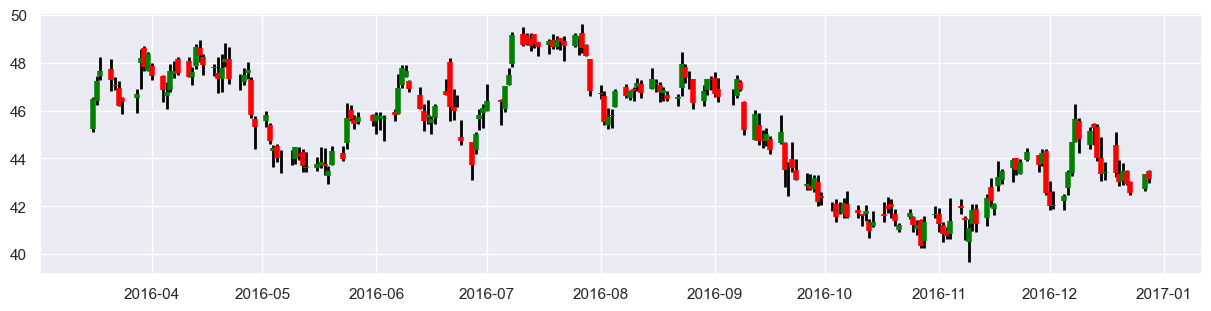

In [54]:
def plot_ohlc(data):
    fig1, ax1 = plt.subplots(figsize=(12,  3), constrained_layout=True)
    
    for i in data.index:

        ax1.vlines(i, ymin=data["low"][i], ymax=data["high"][i], color="black", linewidth=2)
        if data["close"][i] > data["open"][i]:
            ax1.vlines(i, ymin=data["open"][i], ymax=data["close"][i], color="green", linewidth=4)
        elif data["close"][i] < data["open"][i]:
            ax1.vlines(i, ymin=data["close"][i], ymax=data["open"][i], color="red", linewidth=4)
        else:
            ax1.vlines(i, ymin=data["open"][i], ymax=data["close"][i]+0.000001, color="red", linewidth=4)
            
    return fig1, ax1
plot_ohlc(data_comapany_unique[-200:])

In [17]:
# import plotly.graph_objects as go
# from datetime import datetime

# fig = go.Figure(data=[go.Candlestick(x=dataset_1['date'],
#                 open=dataset_1['open'],
#                 high=dataset_1['high'],
#                 low=dataset_1['low'],
#                 close=dataset_1['close'])])
# fig.update_layout(xaxis_rangeslider_visible=False)

# fig.show()

c:\Users\Reza-pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Reza-pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Reza-pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Reza-pc\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before o

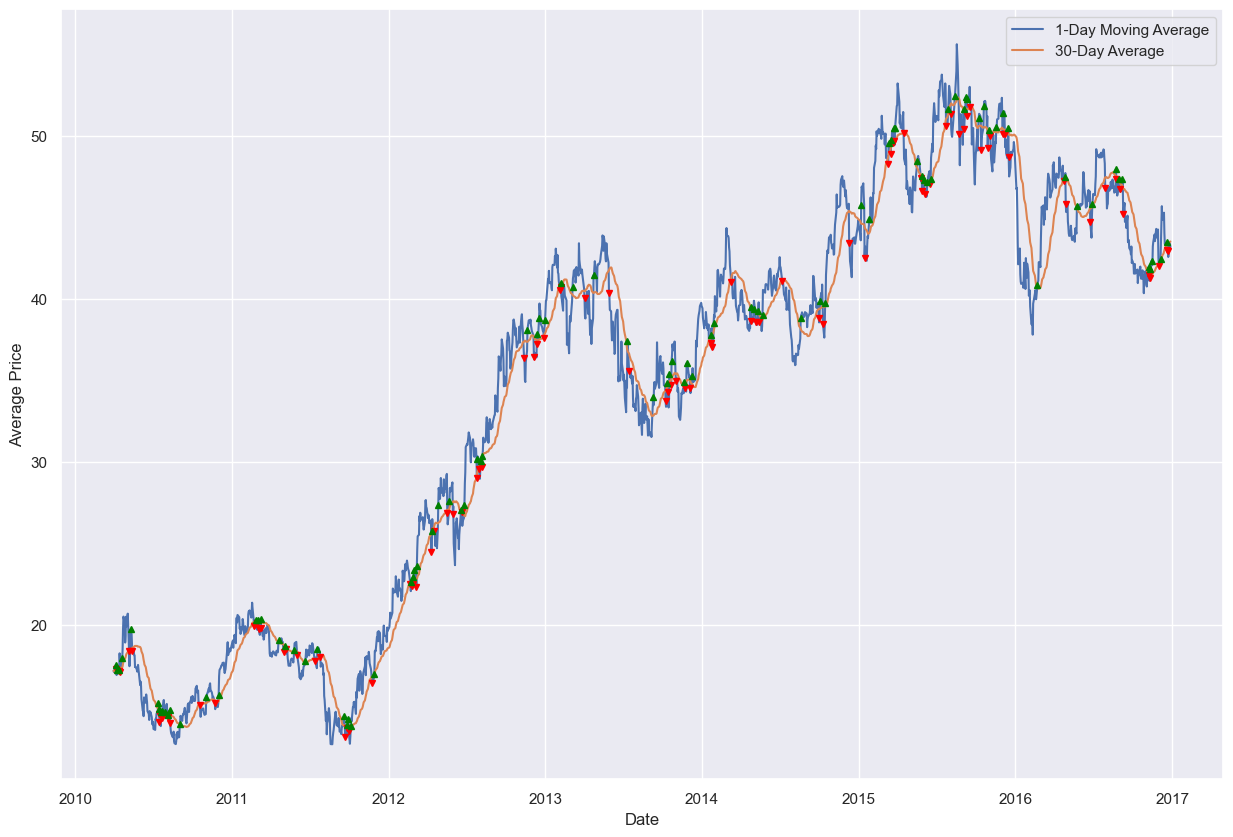

In [18]:
capital = 10000
short_lookback = 1
long_lookback = 30
signals = pd.DataFrame(index=data_comapany_unique.index)
signals['signal'] = 0.0
signals['short_mav'] = data_comapany_unique['close'].rolling(short_lookback, min_periods=1,center=False).mean()
signals['long_mav'] = data_comapany_unique['close'].rolling(long_lookback,min_periods=1,center=False).mean()
signals['signal'][short_lookback:] = np.where(signals['short_mav'][short_lookback:] > signals['long_mav'][short_lookback:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()
signals[signals['positions'] == -1.0]

fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.lineplot(y='short_mav', 
             x=signals.index, 
             data=signals, 
             ax=ax, 
             label=f'{short_lookback}-Day Moving Average',
             )
sns.lineplot(y='long_mav', 
             x=signals.index, 
             data=signals, 
             ax=ax, 
             label=f'{long_lookback}-Day Average',
             )
ax.plot(signals.loc[signals.positions == -1.0].index,                         
          signals.short_mav[signals.positions == -1.0],
          'v',                     
          markersize=5, 
          color='red',
          label='Sell')
ax.plot(signals.loc[signals.positions == 1.0].index,          
          signals.short_mav[signals.positions == 1.0],         
          '^', 
          markersize=5, 
          color='green',
          label='Buy')

ax.set_ylabel('Average Price')
ax.set_xlabel('Date')
plt.show()

StandardScaler :

In [19]:
data_comapany  = data_comapany_unique.filter(['close']).values
scale=StandardScaler()
data_comapany_unique_scale=scale.fit_transform(data_comapany)

Split Train and Test :

In [20]:
train_size = int(len(data_comapany_unique)*0.7)
test_size = len(data_comapany_unique) - train_size

print("Train Size :",train_size,"Test Size :",test_size)

train_data = data_comapany_unique_scale[:train_size ]
test_data = data_comapany_unique_scale[ train_size:]


Train Size : 1190 Test Size : 510


In [21]:
featuer_train = []
labels_train = []

for i in tqdm(range(60, len(train_data))):
    featuer_train.append(train_data[i-60:i, 0])
    labels_train.append(train_data[i, 0])
# print(x_train , y_train)
featuer_train, labels_train = np.array(featuer_train), np.array(labels_train)
featuer_train = np.reshape(featuer_train, (featuer_train.shape[0], featuer_train.shape[1], 1))
print(featuer_train.shape , labels_train.shape)

featuer_test = []
labels_test = []

for i in tqdm(range(60, len(test_data))):
    featuer_test.append(test_data[i-60:i, 0])
    labels_test.append(test_data[i, 0])

featuer_test, labels_test = np.array(featuer_test), np.array(labels_test)
featuer_test = np.reshape(featuer_test, (featuer_test.shape[0], featuer_test.shape[1], 1))
print(featuer_test.shape , labels_test.shape)

100%|██████████| 1130/1130 [00:00<?, ?it/s]


(1130, 60, 1) (1130,)


100%|██████████| 450/450 [00:00<?, ?it/s]

(450, 60, 1) (450,)


plot_history :

In [22]:
def plot_history(history):
    if "loss" in history.history.keys():
        fig1, ax1 = plt.subplots(figsize=(6, 3), constrained_layout=True)
        losses = history.history["loss"]
        last_loss = losses[-1] 
        ax1.plot(losses, label=f"loss: {last_loss:.4f}", color="blue")
        ax1.legend()
        ax1.grid()
        ax1.set_title("Loss Function", fontsize=15)
    if "val_loss" in history.history.keys():
        fig2, ax2 = plt.subplots(figsize=(6, 3), constrained_layout=True)
        val_loss = history.history["val_loss"]
        val_losses = val_loss[-1] 
        ax2.plot(history.history["val_loss"], label=f"val_loss: {val_losses:.4f}", color="green")
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel("Epoch", fontsize=15)
    if "mean_absolute_error" in history.history.keys():
        fig2, ax2 = plt.subplots(figsize=(6, 3), constrained_layout=True)
        mean_absolute_error = history.history["mean_absolute_error"]
        mean_absolute_error = mean_absolute_error[-1] 
        ax2.plot(history.history["mean_absolute_error"], label=f"mean_absolute_error: {mean_absolute_error:.4f}", color="black")
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel("Epoch", fontsize=15)
    if "val_mean_absolute_error" in history.history.keys():
        fig2, ax2 = plt.subplots(figsize=(6, 3), constrained_layout=True)
        val_mean_absolute_error = history.history["mean_absolute_error"]
        val_mean_absolute_error = val_mean_absolute_error[-1] 
        ax2.plot(history.history["val_mean_absolute_error"], label=f"val_mean_absolute_error: {val_mean_absolute_error:.4f}", color="red")
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel("Epoch", fontsize=15)
    return None

Model LSTM :

In [23]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(50, return_sequences= True, input_shape= (featuer_train.shape[1], 1)))
model_LSTM.add(LSTM(64,))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(32))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(16))
model_LSTM.add(Dense(1))
model_LSTM.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])
model_LSTM.summary()

c:\Users\Reza-pc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,465 (165.88 KB)

 Trainable params: 42,465 (165.88 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
LSTM=model_LSTM.fit(featuer_train,labels_train,epochs=100,batch_size=35, validation_split=0.2, verbose=1,callbacks=earlystop)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 0.4161 - mean_absolute_error: 0.4711 - val_loss: 0.0167 - val_mean_absolute_error: 0.1055
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0422 - mean_absolute_error: 0.1565 - val_loss: 0.0146 - val_mean_absolute_error: 0.0974
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0284 - mean_absolute_error: 0.1321 - val_loss: 0.0187 - val_mean_absolute_error: 0.1089
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0285 - mean_absolute_error: 0.1306 - val_loss: 0.0136 - val_mean_absolute_error: 0.0938
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0303 - mean_absolute_error: 0.1357 - val_loss: 0.0155 - val_mean_absolute_error: 0.0993
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0295 - mean_absolute_error: 0.1348 - val_loss: 0.0150 - val_mean_absolute_error: 0.0973
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0245 - mean_absolute_error: 0.1238 - v

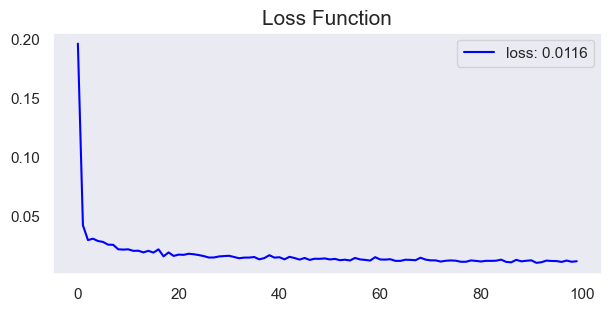

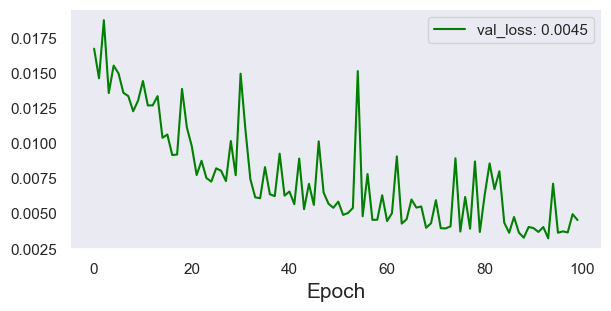

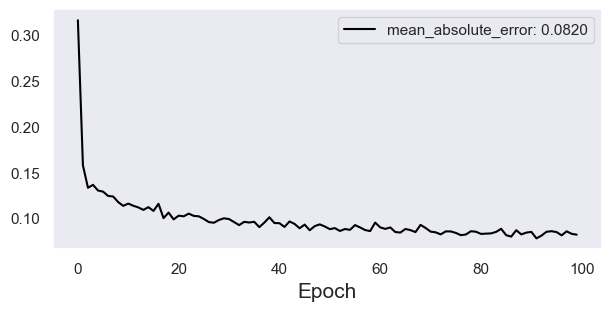

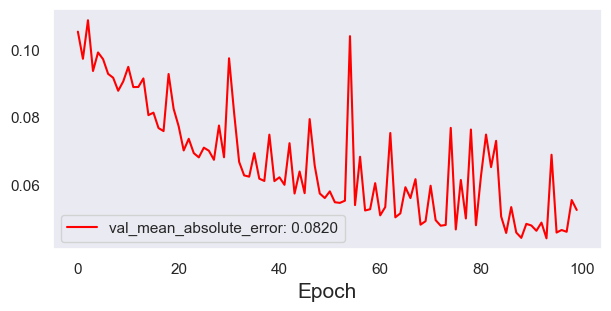

In [25]:
plot_history(LSTM)

evaluate :

In [26]:
model_LSTM.evaluate(featuer_test,labels_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0125 - mean_absolute_error: 0.0946


[0.010336383245885372, 0.08455003798007965]

predict(Training,Testing) :

In [27]:
trainPredict_LSTM = model_LSTM.predict(featuer_train)
testPredict_LSTM = model_LSTM.predict(featuer_test)

trainPredict_LSTM = scale.inverse_transform(trainPredict_LSTM)
trainY = scale.inverse_transform([labels_train])
testPredict_LSTM = scale.inverse_transform(testPredict_LSTM)
testY = scale.inverse_transform([labels_test])

plot_predicted_LSTM = testPredict_LSTM.copy()
plot_predicted_LSTM = plot_predicted_LSTM.reshape(testPredict_LSTM.shape[0], testPredict_LSTM.shape[1])
plot_actual = testY.copy()
plot_actual_LSTM = plot_actual.reshape(testPredict_LSTM.shape[0], testPredict_LSTM.shape[1])
print(plot_actual_LSTM.shape)
print(plot_predicted_LSTM.shape)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(450, 1)
(450, 1)


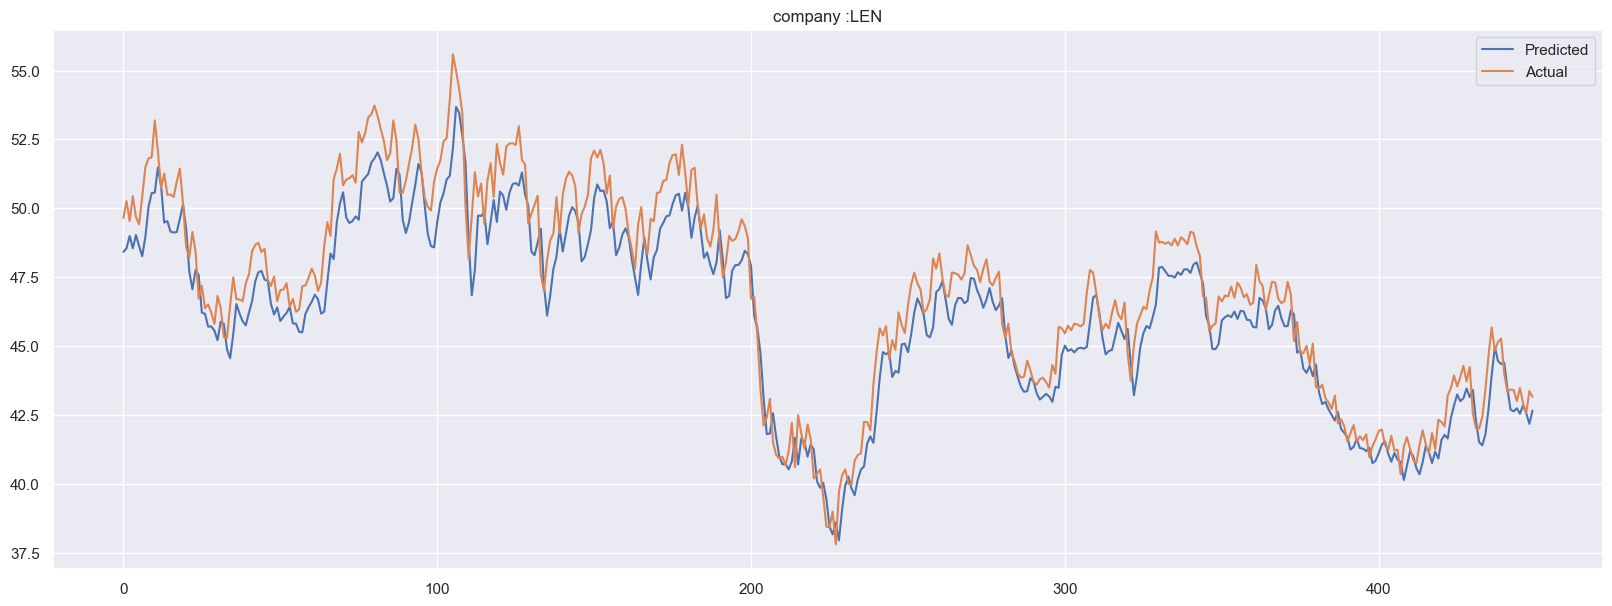

In [28]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted_LSTM), label='Predicted')
plt.plot(pd.DataFrame(plot_actual_LSTM), label='Actual')
plt.title(f'company :{com}')
plt.legend(loc='best')
plt.show()

In [29]:
trainScore_LSTM = mean_squared_error(trainY[0], trainPredict_LSTM[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore_LSTM))
testScore_LSTM = mean_squared_error(testY[0], testPredict_LSTM[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore_LSTM))

Train Score: 0.73 RMSE
Test Score: 1.24 RMSE


In [30]:
stock_prices = data_comapany_unique.close.values.astype('float32')
stock_prices = stock_prices.reshape(len(stock_prices), 1)

In [31]:
trainPredictPlot_LSTM = np.empty_like(stock_prices)
trainPredictPlot_LSTM[:,:] = np.nan
trainPredictPlot_LSTM[17:len(trainPredict_LSTM)+17, :] = trainPredict_LSTM

testPredictPlot_LSTM = np.empty_like(stock_prices)
testPredictPlot_LSTM[:, :] = np.nan
testPredictPlot_LSTM[(len(stock_prices) - testPredict_LSTM.shape[0]):len(stock_prices), :] = testPredict_LSTM

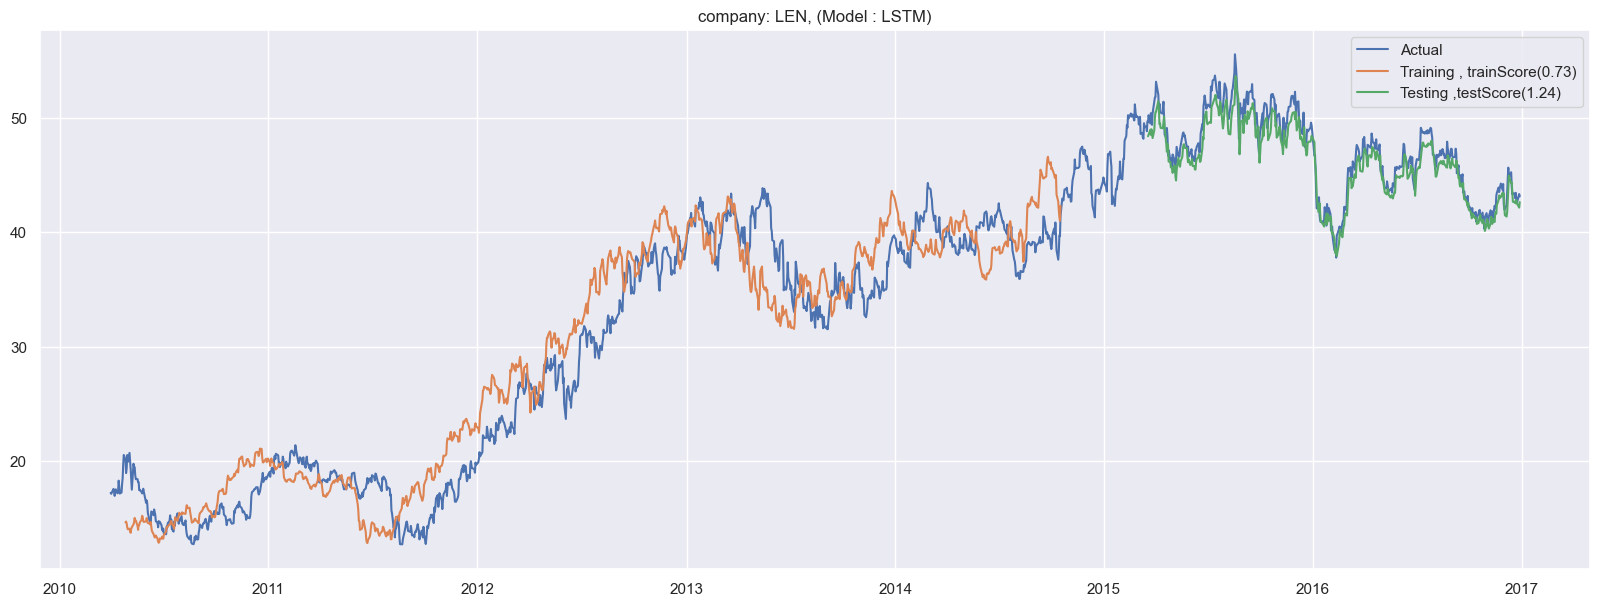

In [32]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(stock_prices, columns=["close"], index=data_comapany_unique.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot_LSTM, columns=["close"], index=data_comapany_unique.index).close, label=f'Training , trainScore({round(trainScore_LSTM,2)})')
plt.plot(pd.DataFrame(testPredictPlot_LSTM, columns=["close"], index=data_comapany_unique.index).close, label=f'Testing ,testScore({round(testScore_LSTM,2)}) ')
plt.title(f'company: {com}, (Model : LSTM)')
plt.legend(loc='best')
plt.show()

Model RNN :

In [33]:
from keras.layers import SimpleRNN

In [34]:
model_RNN = Sequential()
model_RNN.add(SimpleRNN(50, return_sequences= True, input_shape= (featuer_train.shape[1], 1)))
model_RNN.add(SimpleRNN(64,))
model_RNN.add(Dropout(0.2))
model_RNN.add(Dense(32))
model_RNN.add(Dropout(0.2))
model_RNN.add(Dense(16))
model_RNN.add(Dense(1))
model_RNN.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])
model_RNN.summary()

c:\Users\Reza-pc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         7,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,585 (49.16 KB)

 Trainable params: 12,585 (49.16 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
RNN=model_RNN.fit(featuer_train,labels_train,epochs=100,batch_size=35, validation_split=0.2, verbose=1,callbacks=earlystop)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.3488 - mean_absolute_error: 0.4575 - val_loss: 0.0186 - val_mean_absolute_error: 0.1091
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0934 - mean_absolute_error: 0.2393 - val_loss: 0.0163 - val_mean_absolute_error: 0.1044
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0534 - mean_absolute_error: 0.1818 - val_loss: 0.0121 - val_mean_absolute_error: 0.0890
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0333 - mean_absolute_error: 0.1451 - val_loss: 0.0073 - val_mean_absolute_error: 0.0679
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0350 - mean_absolute_error: 0.1500 - val_loss: 0.0056 - val_mean_absolute_error: 0.0594
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0326 - mean_absolute_error: 0.1384 - val_loss: 0.0070 - val_mean_absolute_error: 0.0653
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0258 - mean_absolute_error: 0.1218 - v

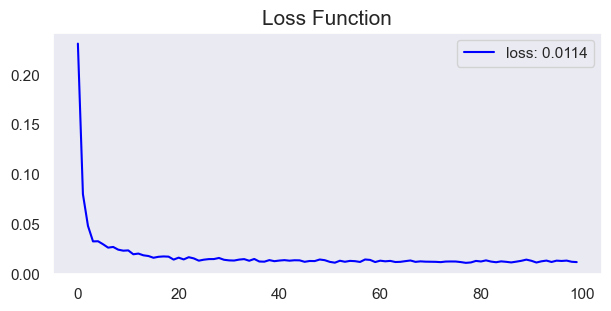

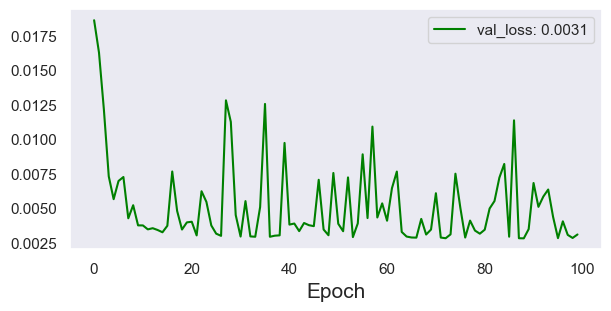

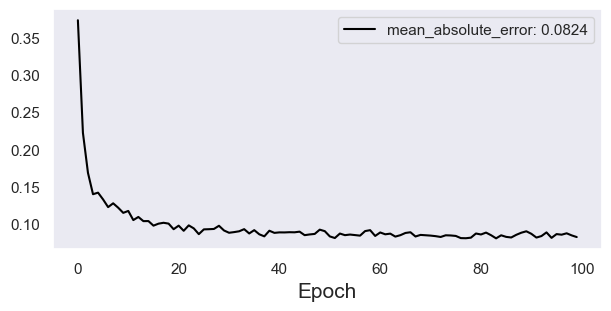

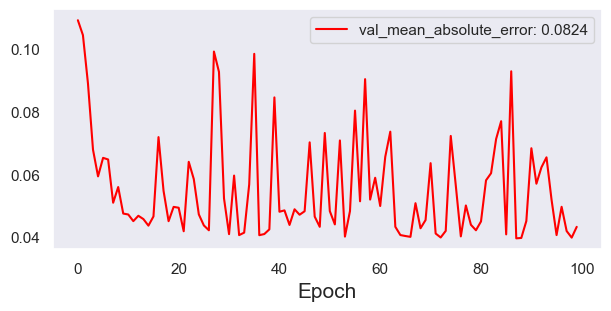

In [36]:
plot_history(RNN)

evaluate :

In [37]:
model_RNN.evaluate(featuer_test,labels_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0067 - mean_absolute_error: 0.0658


[0.005564586725085974, 0.05856206640601158]

predict(Training,Testing) :

In [38]:
trainPredict_RNN = model_RNN.predict(featuer_train)
testPredict_RNN = model_RNN.predict(featuer_test)

trainPredict_RNN = scale.inverse_transform(trainPredict_RNN)
trainY = scale.inverse_transform([labels_train])
testPredict_RNN = scale.inverse_transform(testPredict_RNN)
testY = scale.inverse_transform([labels_test])

plot_predicted_RNN = testPredict_RNN.copy()
plot_predicted_RNN = plot_predicted_LSTM.reshape(testPredict_RNN.shape[0], testPredict_RNN.shape[1])
plot_actual = testY.copy()
plot_actual_RNN = plot_actual.reshape(testPredict_RNN.shape[0], testPredict_RNN.shape[1])
print(plot_predicted_RNN.shape)
print(plot_actual_RNN.shape)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
(450, 1)
(450, 1)


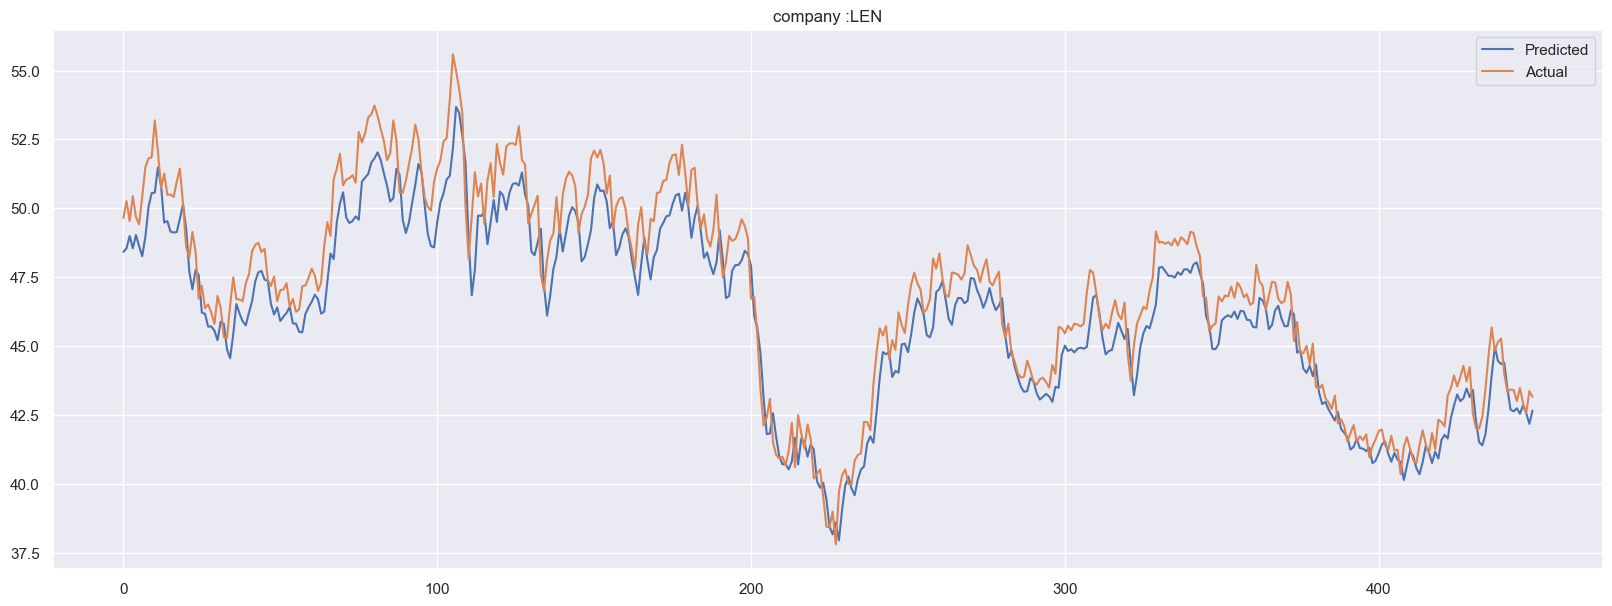

In [39]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted_RNN), label='Predicted')
plt.plot(pd.DataFrame(plot_actual_RNN), label='Actual')
plt.title(f'company :{com}')
plt.legend(loc='best')
plt.show()

In [40]:
trainScore_RNN = mean_squared_error(trainY[0], trainPredict_RNN[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore_RNN))
testScore_RNN = mean_squared_error(testY[0], testPredict_RNN[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore_RNN))

Train Score: 0.68 RMSE
Test Score: 0.91 RMSE


In [41]:
trainPredictPlot_RNN= np.empty_like(stock_prices)
trainPredictPlot_RNN[:,:] = np.nan
trainPredictPlot_RNN[17:len(trainPredict_RNN)+17, :] = trainPredict_RNN

testPredictPlot_RNN = np.empty_like(stock_prices)
testPredictPlot_RNN[:, :] = np.nan
testPredictPlot_RNN[(len(stock_prices) - testPredict_RNN.shape[0]):len(stock_prices), :] = testPredict_RNN

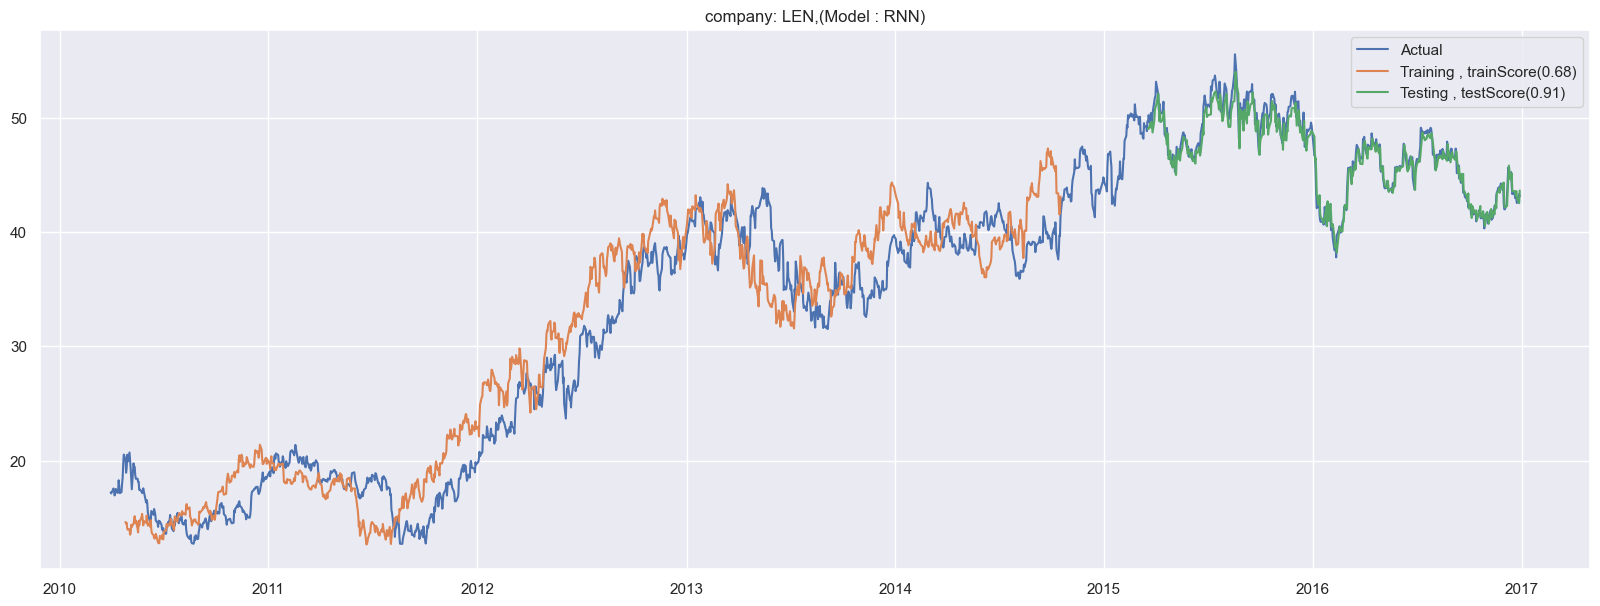

In [42]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(stock_prices, columns=["close"], index=data_comapany_unique.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot_RNN, columns=["close"], index=data_comapany_unique.index).close, label=f'Training , trainScore({round(trainScore_RNN,2)})')
plt.plot(pd.DataFrame(testPredictPlot_RNN, columns=["close"], index=data_comapany_unique.index).close, label=f'Testing , testScore({round(testScore_RNN,2)})')
plt.title(f'company: {com},(Model : RNN)')
plt.legend(loc='best')
plt.show()

Model GRU :

In [43]:
from keras.layers import GRU

In [44]:
model_GRU = Sequential()
model_GRU.add(SimpleRNN(50, return_sequences= True, input_shape= (featuer_train.shape[1], 1)))
model_GRU.add(SimpleRNN(64,))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(32))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(16))
model_GRU.add(Dense(1))
model_GRU.compile(optimizer= 'adam', loss= 'mse' , metrics= ["mean_absolute_error"])
model_GRU.summary()

c:\Users\Reza-pc\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 60, 50)         │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 64)             │         7,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,585 (49.16 KB)

 Trainable params: 12,585 (49.16 KB)

 Non-trainable params: 0 (0.00 B)

In [45]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
GRU=model_GRU.fit(featuer_train,labels_train,epochs=100,batch_size=35, validation_split=0.2, verbose=1,callbacks=earlystop)

Epoch 1/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.3156 - mean_absolute_error: 0.4209 - val_loss: 0.0097 - val_mean_absolute_error: 0.0813
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0730 - mean_absolute_error: 0.2165 - val_loss: 0.0085 - val_mean_absolute_error: 0.0752
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0466 - mean_absolute_error: 0.1654 - val_loss: 0.0051 - val_mean_absolute_error: 0.0556
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0432 - mean_absolute_error: 0.1576 - val_loss: 0.0045 - val_mean_absolute_error: 0.0523
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0336 - mean_absolute_error: 0.1394 - val_loss: 0.0049 - val_mean_absolute_error: 0.0532
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0288 - mean_absolute_error: 0.1282 - val_loss: 0.0088 - val_mean_absolute_error: 0.0755
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0274 - mean_absolute_error: 0.1273 - v

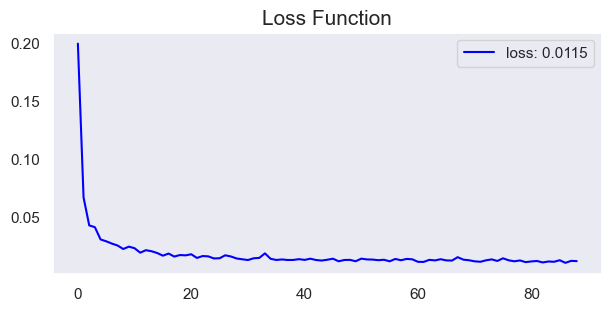

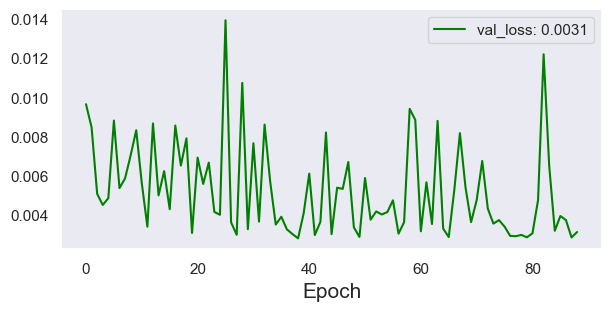

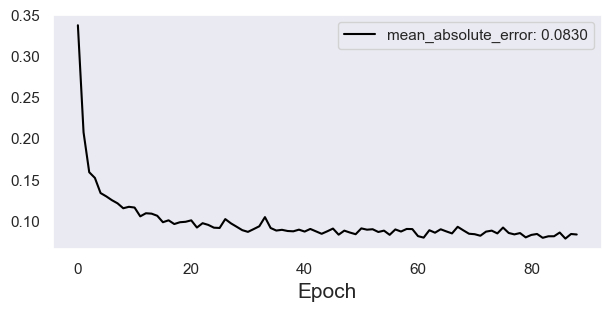

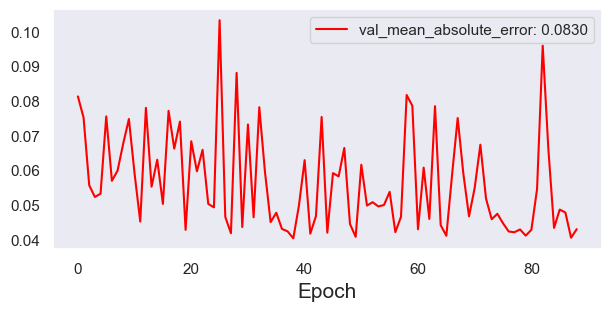

In [46]:
plot_history(GRU)

evaluate :

In [47]:
model_GRU.evaluate(featuer_test,labels_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - mean_absolute_error: 0.1070


[0.012254145927727222, 0.09057750552892685]

predict(Training,Testing) :

In [48]:
trainPredict_GRU = model_GRU.predict(featuer_train)
testPredict_GRU = model_GRU.predict(featuer_test)

trainPredict_GRU = scale.inverse_transform(trainPredict_GRU)
trainY = scale.inverse_transform([labels_train])
testPredict_GRU = scale.inverse_transform(testPredict_GRU)
testY = scale.inverse_transform([labels_test])

plot_predicted_GRU = testPredict_GRU.copy()
plot_predicted_GRU = plot_predicted_LSTM.reshape(testPredict_GRU.shape[0], testPredict_GRU.shape[1])
plot_actual = testY.copy()
plot_actual_GRU = plot_actual.reshape(testPredict_GRU.shape[0], testPredict_GRU.shape[1])
print(plot_predicted_RNN.shape)
print(plot_actual_GRU.shape)

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
(450, 1)
(450, 1)


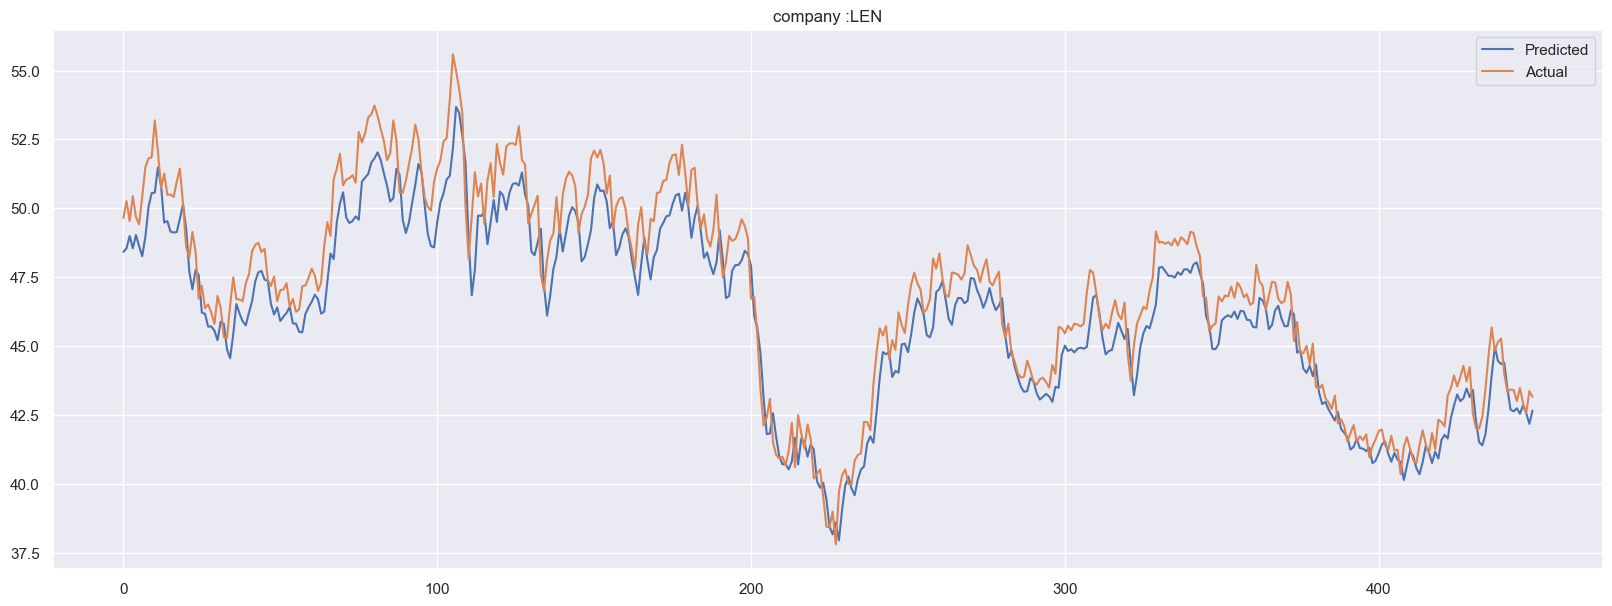

In [49]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(plot_predicted_LSTM), label='Predicted')
plt.plot(pd.DataFrame(plot_actual_LSTM), label='Actual')
plt.title(f'company :{com}')
plt.legend(loc='best')
plt.show()

In [50]:
trainScore_GRU = mean_squared_error(trainY[0], trainPredict_GRU[:,0]) ** .5
print('Train Score: %.2f RMSE' % (trainScore_GRU))
testScore_GRU = mean_squared_error(testY[0], testPredict_GRU[:,0]) ** .5
print('Test Score: %.2f RMSE' % (testScore_GRU))

Train Score: 0.74 RMSE
Test Score: 1.35 RMSE


In [51]:
trainPredictPlot_GRU= np.empty_like(stock_prices)
trainPredictPlot_GRU[:,:] = np.nan
trainPredictPlot_GRU[17:len(trainPredict_GRU)+17, :] = trainPredict_GRU

testPredictPlot_GRU = np.empty_like(stock_prices)
testPredictPlot_GRU[:, :] = np.nan
testPredictPlot_GRU[(len(stock_prices) - testPredict_GRU.shape[0]):len(stock_prices), :] = testPredict_GRU

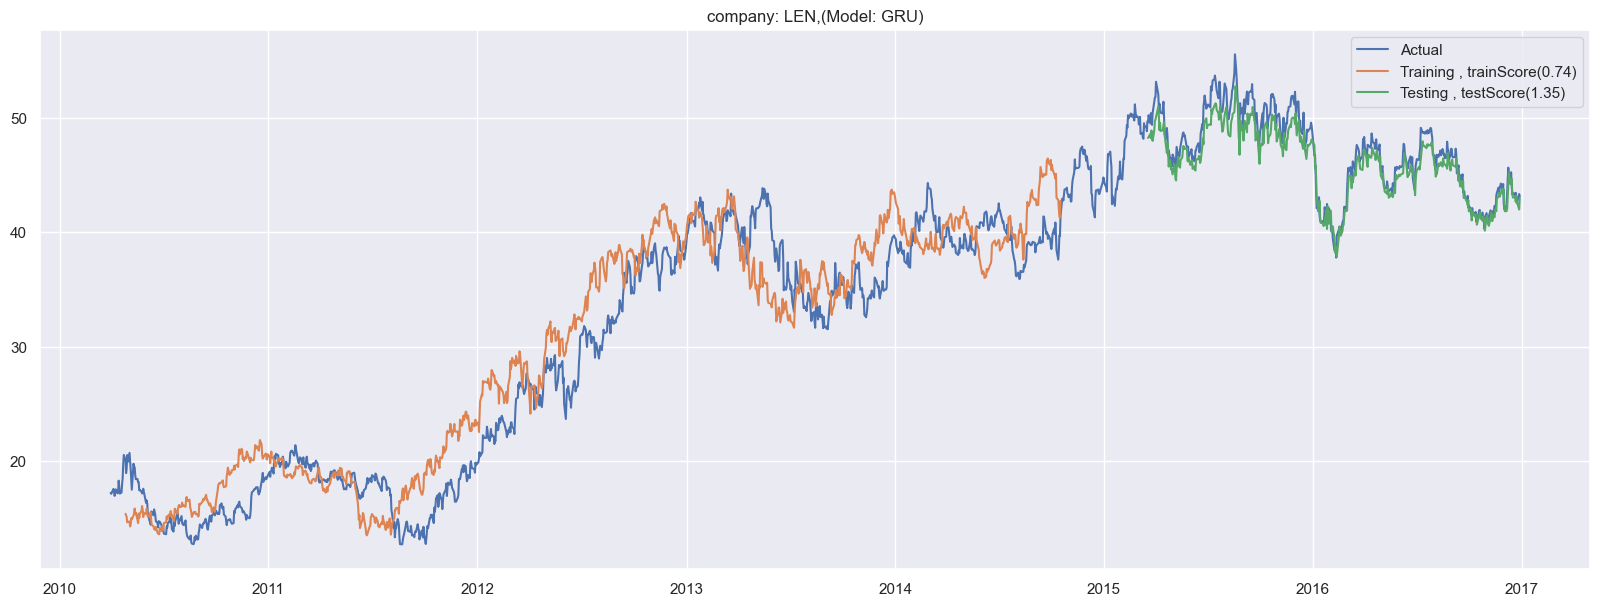

In [52]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(stock_prices, columns=["close"], index=data_comapany_unique.index).close, label='Actual')
plt.plot(pd.DataFrame(trainPredictPlot_GRU, columns=["close"], index=data_comapany_unique.index).close, label=f'Training , trainScore({round(trainScore_GRU,2)})')
plt.plot(pd.DataFrame(testPredictPlot_GRU, columns=["close"], index=data_comapany_unique.index).close, label=f'Testing , testScore({round(testScore_GRU,2)})')
plt.title(f'company: {com},(Model: GRU)')
plt.legend(loc='best')
plt.show()

LSTM / RNN / GRU :

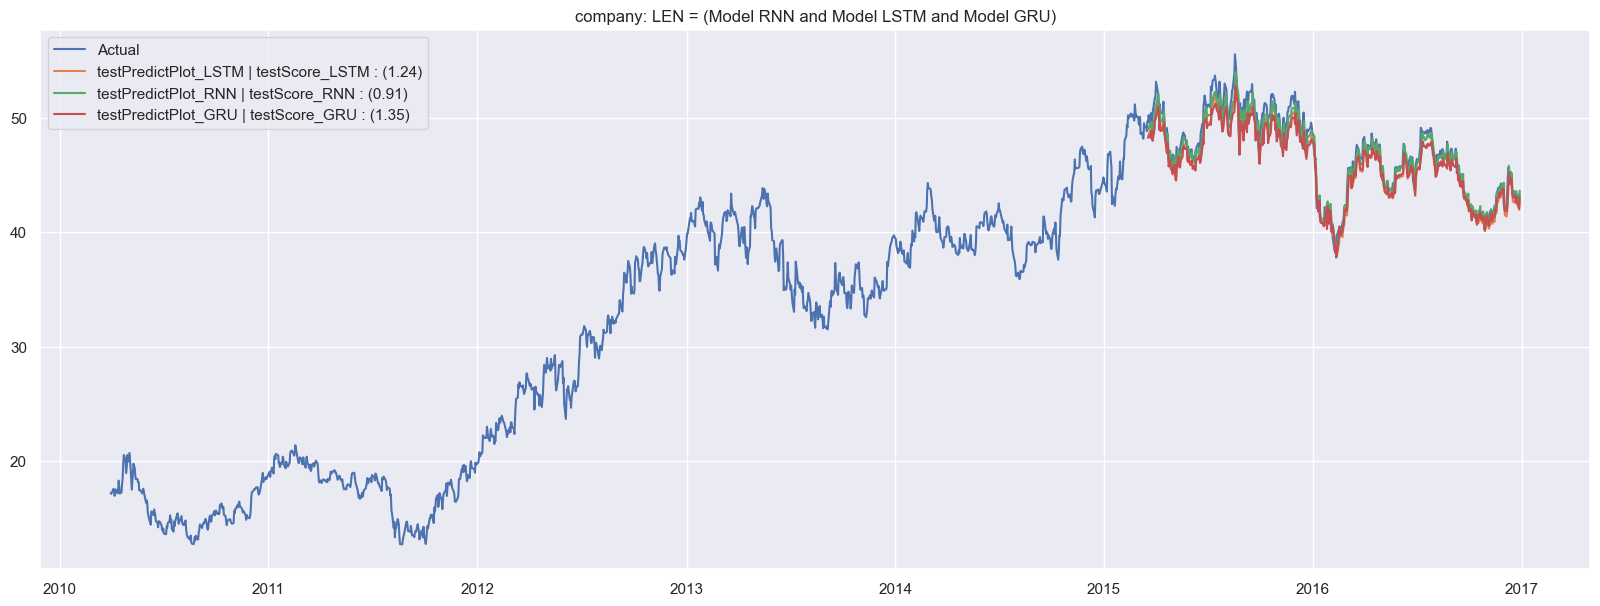

In [53]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(stock_prices, columns=["close"], index=data_comapany_unique.index).close, label='Actual')
plt.plot(pd.DataFrame(testPredictPlot_LSTM, columns=["close"], index=data_comapany_unique.index).close, label=f'testPredictPlot_LSTM | testScore_LSTM : ({round(testScore_LSTM,2)})')
plt.plot(pd.DataFrame(testPredictPlot_RNN, columns=["close"], index=data_comapany_unique.index).close, label=f'testPredictPlot_RNN | testScore_RNN : ({round(testScore_RNN,2)})')
plt.plot(pd.DataFrame(testPredictPlot_GRU, columns=["close"], index=data_comapany_unique.index).close, label=f'testPredictPlot_GRU | testScore_GRU : ({round(testScore_GRU,2)})')
plt.title(f'company: {com} = (Model RNN and Model LSTM and Model GRU)')
plt.legend(loc='best')
plt.show()